# Semi Synthetic Experiments

Analyze the performance of various algorithms to solve the joint matching + activity task, when the number of volunteers is large and structured

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import random 
import matplotlib.pyplot as plt
import json 
import argparse 
import sys
import secrets

In [3]:
from rmab.simulator import RMABSimulator
from rmab.omniscient_policies import *
from rmab.fr_dynamics import get_all_transitions
from rmab.mcts_policies import full_mcts_policy
from rmab.utils import get_save_path, delete_duplicate_results
import resource

/usr0/home/naveenr/miniconda3/envs/food/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
torch.cuda.set_per_process_memory_fraction(0.5)
torch.set_num_threads(1)
resource.setrlimit(resource.RLIMIT_AS, (30 * 1024 * 1024 * 1024, -1))

In [5]:
is_jupyter = 'ipykernel' in sys.modules

In [90]:
if is_jupyter: 
    seed        = 42
    n_arms      = 2
    volunteers_per_arm = 2
    budget      = 3
    discount    = 0.9
    alpha       = 3 
    n_episodes  = 30
    episode_len = 20 
    n_epochs    = 10 
    save_with_date = False 
    TIME_PER_RUN = 0.01 * 1000
    lamb = 0.5
    prob_distro = 'uniform'
else:
    parser = argparse.ArgumentParser()
    parser.add_argument('--n_arms',         '-N', help='num beneficiaries (arms)', type=int, default=2)
    parser.add_argument('--volunteers_per_arm',         '-V', help='volunteers per arm', type=int, default=5)
    parser.add_argument('--episode_len',    '-H', help='episode length', type=int, default=20)
    parser.add_argument('--n_episodes',     '-T', help='num episodes', type=int, default=125)
    parser.add_argument('--budget',         '-B', help='budget', type=int, default=3)
    parser.add_argument('--n_epochs',       '-E', help='number of epochs (num_repeats)', type=int, default=1)
    parser.add_argument('--discount',       '-d', help='discount factor', type=float, default=0.9)
    parser.add_argument('--alpha',          '-a', help='alpha: for conf radius', type=float, default=3)
    parser.add_argument('--lamb',          '-l', help='lambda for matching-engagement tradeoff', type=float, default=1)
    parser.add_argument('--seed',           '-s', help='random seed', type=int, default=42)
    parser.add_argument('--prob_distro',           '-p', help='which prob distro [uniform,uniform_small,uniform_large,normal]', type=str, default='uniform')
    parser.add_argument('--time_per_run',      '-t', help='time per MCTS run', type=float, default=.01*1000)
    parser.add_argument('--use_date', action='store_true')

    args = parser.parse_args()

    n_arms      = args.n_arms
    volunteers_per_arm = args.volunteers_per_arm
    budget      = args.budget
    discount    = args.discount
    alpha       = args.alpha 
    seed        = args.seed
    n_episodes  = args.n_episodes
    episode_len = args.episode_len
    n_epochs    = args.n_epochs
    lamb = args.lamb
    save_with_date = args.use_date
    TIME_PER_RUN = args.time_per_run
    prob_distro = args.prob_distro

save_name = secrets.token_hex(4)  

In [91]:
n_states = 2
n_actions = 2

In [92]:
all_population_size = 100 # number of random arms to generate
all_transitions = get_all_transitions(all_population_size)

In [93]:
def create_environment(seed):
    random.seed(seed)
    np.random.seed(seed)

    all_features = np.arange(all_population_size)

    if prob_distro == 'uniform':
        match_probabilities = [np.random.random() for i in range(all_population_size * volunteers_per_arm)] 
    elif prob_distro == 'uniform_small':
        match_probabilities = [np.random.random()/4 for i in range(all_population_size * volunteers_per_arm)] 
    elif prob_distro == 'uniform_large':
        match_probabilities = [np.random.random()/4+0.75 for i in range(all_population_size * volunteers_per_arm)] 
    elif prob_distro == 'normal':
        match_probabilities = [np.clip(random.gauss(0.25, 0.1),0,1) for i in range(all_population_size * volunteers_per_arm)] 
    else:
        raise Exception("{} probability distro not found".format(prob_distro))
    np.random.seed(seed)
    random.seed(seed)
    simulator = RMABSimulator(all_population_size, all_features, all_transitions,
                n_arms, volunteers_per_arm, episode_len, n_epochs, n_episodes, budget, discount,number_states=n_states, reward_style='match',match_probability_list=match_probabilities,TIME_PER_RUN=TIME_PER_RUN)

    return simulator 

In [94]:
results = {}
results['parameters'] = {'seed'      : seed,
        'n_arms'    : n_arms,
        'volunteers_per_arm': volunteers_per_arm, 
        'budget'    : budget,
        'discount'  : discount, 
        'alpha'     : alpha, 
        'n_episodes': n_episodes, 
        'episode_len': episode_len, 
        'n_epochs'  : n_epochs, 
        'lamb': lamb,
        'time_per_run': TIME_PER_RUN, 
        'prob_distro': prob_distro} 

## Index Policies

In [153]:
policy = whittle_policy
name = "linear_whittle"

# TODO: Remove looping through seeds
tot_reward = []
for seed in [42,43,44]:
    simulator = create_environment(seed)
    whittle_match, whittle_active_rate = run_heterogenous_policy(simulator, n_episodes, n_epochs, discount,policy,seed,lamb=lamb,should_train=True,test_T=100)
    time_whittle = simulator.time_taken
    whittle_discounted_reward = get_discounted_reward(whittle_match,whittle_active_rate,discount,lamb)
    tot_reward.append(whittle_discounted_reward)

print(np.mean(tot_reward),np.std(tot_reward))

results['{}_reward'.format(name)] = whittle_discounted_reward
results['{}_match'.format(name)] = np.mean(whittle_match) 
results['{}_active'.format(name)] = np.mean(whittle_active_rate)
results['{}_time'.format(name)] = time_whittle 

acting should always be good! 0.000 < 0.044
acting should always be good! 0.000 < 0.162
acting should always be good! 0.108 < 0.183
good start state should always be good! 0.380 < 0.508
good start state should always be good! 0.506 < 0.760
cohort [83 53]
cohort [41 39]
cohort [79 72]
cohort [92 64]
cohort [ 7 38]
cohort [12 59]
cohort [48 64]
cohort [18 53]
cohort [69 64]
cohort [46 87]
instance 0, ep 1
instance 0, ep 2
instance 0, ep 3
instance 0, ep 4
instance 0, ep 5
instance 0, ep 6
instance 0, ep 7
instance 0, ep 8
instance 0, ep 9
instance 0, ep 10
instance 0, ep 11
instance 0, ep 12
instance 0, ep 13
instance 0, ep 14
instance 0, ep 15
instance 0, ep 16
instance 0, ep 17
instance 0, ep 18
instance 0, ep 19
instance 0, ep 20
instance 0, ep 21
instance 0, ep 22
instance 0, ep 23
instance 0, ep 24
instance 0, ep 25
instance 0, ep 26
instance 0, ep 27
instance 0, ep 28
instance 0, ep 29
instance 1, ep 1
instance 1, ep 2
instance 1, ep 3
instance 1, ep 4
instance 1, ep 5
instance 1, 

In [154]:
tot_reward

[6.2316652024201815, 6.916812611632911, 6.5696840951472595]

In [155]:
policy = greedy_policy
name = "greedy"

# TODO: Remove looping through seeds
tot_reward = []
for seed in [42,43,44]:
    simulator = create_environment(seed)
    whittle_match, whittle_active_rate = run_heterogenous_policy(simulator, n_episodes, n_epochs, discount,policy,seed,lamb=lamb,should_train=True,test_T=100)
    time_whittle = simulator.time_taken
    whittle_discounted_reward = get_discounted_reward(whittle_match,whittle_active_rate,discount,lamb)
    tot_reward.append(whittle_discounted_reward)

print(np.mean(tot_reward),np.std(tot_reward))

results['{}_reward'.format(name)] = whittle_discounted_reward
results['{}_match'.format(name)] = np.mean(whittle_match) 
results['{}_active'.format(name)] = np.mean(whittle_active_rate)
results['{}_time'.format(name)] = time_whittle 

acting should always be good! 0.000 < 0.044
acting should always be good! 0.000 < 0.162
acting should always be good! 0.108 < 0.183
good start state should always be good! 0.380 < 0.508
good start state should always be good! 0.506 < 0.760
cohort [83 53]
cohort [41 39]
cohort [79 72]
cohort [92 64]
cohort [ 7 38]
cohort [12 59]
cohort [48 64]
cohort [18 53]
cohort [69 64]
cohort [46 87]
instance 0, ep 1
instance 0, ep 2
instance 0, ep 3
instance 0, ep 4
instance 0, ep 5
instance 0, ep 6
instance 0, ep 7
instance 0, ep 8
instance 0, ep 9
instance 0, ep 10
instance 0, ep 11
instance 0, ep 12
instance 0, ep 13
instance 0, ep 14
instance 0, ep 15
instance 0, ep 16
instance 0, ep 17
instance 0, ep 18
instance 0, ep 19
instance 0, ep 20
instance 0, ep 21
instance 0, ep 22
instance 0, ep 23
instance 0, ep 24
instance 0, ep 25
instance 0, ep 26
instance 0, ep 27
instance 0, ep 28
instance 0, ep 29
instance 1, ep 1
instance 1, ep 2
instance 1, ep 3
instance 1, ep 4
instance 1, ep 5
instance 1, 

In [156]:
tot_reward

[6.073545480796791, 6.278619554542383, 6.251865818548357]

In [151]:
per_epoch_function = q_iteration_epoch

tot_reward = []

# TODO: Remove this seed 
for seed in [42,43,44]:
    simulator = create_environment(seed)
    simulator.mcts_test_iterations = 10
    simulator.mcts_train_iterations = 10

    # TODO: Remove the per_epoch_function
    policy = full_mcts_policy 
    name = "mcts"
    mcts_match, mcts_active_rate,memory = run_heterogenous_policy(simulator, n_episodes, n_epochs, discount,policy,seed,lamb=lamb,get_memory=True,should_train=True,test_T=100)#,per_epoch_function=per_epoch_function)
    time_mcts = simulator.time_taken
    mcts_discounted_reward = get_discounted_reward(mcts_match,mcts_active_rate,discount,lamb)
    tot_reward.append(mcts_discounted_reward)

print(np.mean(tot_reward),np.std(tot_reward))

results['{}_reward'.format(name)] = mcts_discounted_reward
results['{}_match'.format(name)] = np.mean(mcts_match) 
results['{}_active'.format(name)] = np.mean(mcts_active_rate)
results['{}_time'.format(name)] = time_mcts 

acting should always be good! 0.000 < 0.044
acting should always be good! 0.000 < 0.162
acting should always be good! 0.108 < 0.183
good start state should always be good! 0.380 < 0.508
good start state should always be good! 0.506 < 0.760
cohort [83 53]
cohort [41 39]
cohort [79 72]
cohort [92 64]
cohort [ 7 38]
cohort [12 59]
cohort [48 64]
cohort [18 53]
cohort [69 64]
cohort [46 87]
instance 0, ep 1
instance 0, ep 2
instance 0, ep 3
instance 0, ep 4
instance 0, ep 5
instance 0, ep 6
instance 0, ep 7
instance 0, ep 8
instance 0, ep 9
instance 0, ep 10
instance 0, ep 11
instance 0, ep 12
instance 0, ep 13
instance 0, ep 14
instance 0, ep 15
instance 0, ep 16
instance 0, ep 17
instance 0, ep 18
instance 0, ep 19
instance 0, ep 20
instance 0, ep 21
instance 0, ep 22
instance 0, ep 23
instance 0, ep 24
instance 0, ep 25
instance 0, ep 26
instance 0, ep 27
instance 0, ep 28
instance 0, ep 29
instance 1, ep 1
instance 1, ep 2
instance 1, ep 3
instance 1, ep 4
instance 1, ep 5
instance 1, 

In [152]:
tot_reward

[6.22936920936431, 6.708754189464926, 6.555269466568076]

In [157]:
if is_jupyter:
    tot_reward = []
    policy = q_iteration_policy
    per_epoch_function = q_iteration_epoch
    name = "optimal"
    # TODO: Remove this seed 
    for seed in [42,43,44]:
        simulator = create_environment(seed)
        optimal_match, optimal_active_rate = run_heterogenous_policy(simulator, n_episodes, n_epochs, discount,policy,seed,lamb=lamb,per_epoch_function=per_epoch_function,should_train=True,test_T=100)
        time_optimal = simulator.time_taken
        optimal_discounted_reward = get_discounted_reward(optimal_match,optimal_active_rate,discount,lamb)
        tot_reward.append(optimal_discounted_reward)
    print(np.mean(tot_reward),np.std(tot_reward))


acting should always be good! 0.000 < 0.044
acting should always be good! 0.000 < 0.162
acting should always be good! 0.108 < 0.183
good start state should always be good! 0.380 < 0.508
good start state should always be good! 0.506 < 0.760
cohort [83 53]
cohort [41 39]
cohort [79 72]
cohort [92 64]
cohort [ 7 38]
cohort [12 59]
cohort [48 64]
cohort [18 53]
cohort [69 64]
cohort [46 87]
instance 0, ep 1
instance 0, ep 2
instance 0, ep 3
instance 0, ep 4
instance 0, ep 5
instance 0, ep 6
instance 0, ep 7
instance 0, ep 8
instance 0, ep 9
instance 0, ep 10
instance 0, ep 11
instance 0, ep 12
instance 0, ep 13
instance 0, ep 14
instance 0, ep 15
instance 0, ep 16
instance 0, ep 17
instance 0, ep 18
instance 0, ep 19
instance 0, ep 20
instance 0, ep 21
instance 0, ep 22
instance 0, ep 23
instance 0, ep 24
instance 0, ep 25
instance 0, ep 26
instance 0, ep 27
instance 0, ep 28
instance 0, ep 29
instance 1, ep 1
instance 1, ep 2
instance 1, ep 3
instance 1, ep 4
instance 1, ep 5
instance 1, 

In [158]:
tot_reward

[6.260763731634402, 6.888884374988619, 6.591247461149135]

In [159]:
if is_jupyter:
    def plot_sliding_window(data):
        return [np.mean(data[i:i+100]) for i in range(len(data)-100)]
    policy_loss_1 = memory[-5]
    value_loss_1 = memory[-9]

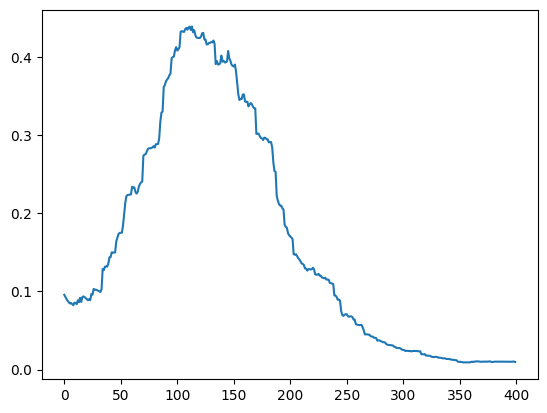

In [160]:
if is_jupyter:  
    plt.plot(plot_sliding_window(value_loss_1))

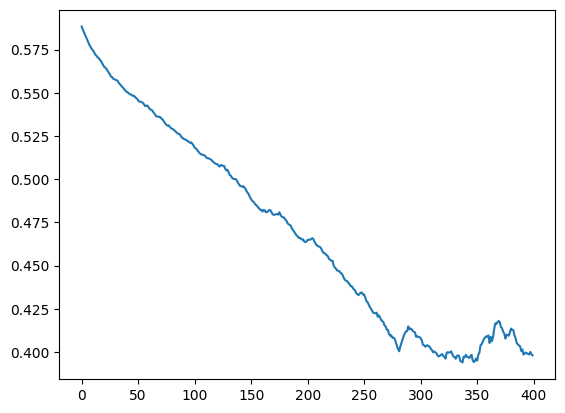

In [161]:
if is_jupyter:
    plt.plot(plot_sliding_window(policy_loss_1))

## Write Data

In [41]:
save_path = get_save_path('semi_synthetic_mcts',save_name,seed,use_date=save_with_date)

In [42]:
delete_duplicate_results('semi_synthetic_mcts',"",results)

In [43]:
json.dump(results,open('../results/'+save_path,'w'))